<img src="ost_logo.png" width="240" height="240" align="right"/>
<div style="text-align: left"> <b> Machine Learning </b> <br> MSE FTP MachLe <br> 
<a href="mailto:christoph.wuersch@ost.ch"> Christoph Würsch </a> </div>

# ML11 A5 Detecting similar Faces using `DBSCAN`?

The labelled faces dataset of sckit-learn contains gray scale images of 62 differnet famous personalites
from politics. In this exercise, we assume that there are no target labels, i.e. the names of
the persons are *unknown*. We want to find a method to cluster similar images. This can be done
using a _dimensionality reduction algorithm like PCA_ for feature generation and a subsequent
clustering e.g. using `DBSCAN`.

In [20]:
%matplotlib inline
from IPython.display import set_matplotlib_formats, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

plt.rcParams['image.cmap'] = "gray"

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

### (a) Loading the Faces Dataset

Open the Jupyter notebook `DBSCAN_DetectSimilarFaces.jpynb` and have a look at the
first few faces of the dataset. Not every person is represented equally frequent in this
unbalanced dataset. For classification, we would have to take this into account. We extract
the first 50 images of each person and put them into a flat array called X_people. The
correspinding targets (y-values, names), are storeed in the y_people array.

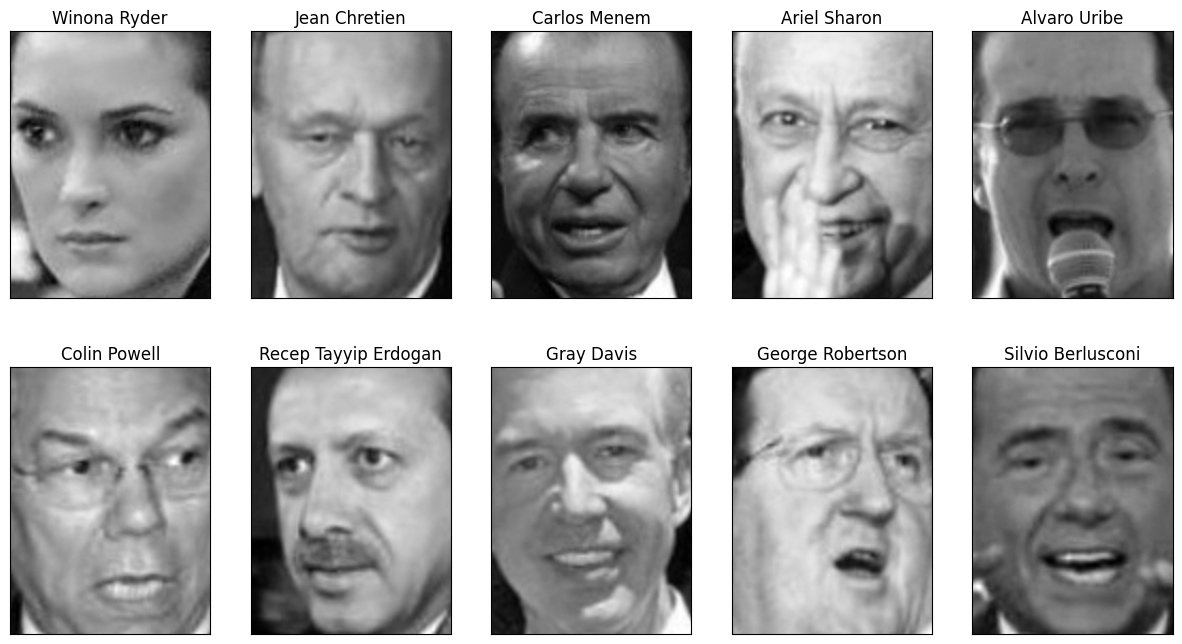

In [22]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people(min_faces_per_person=20, resize=2)
image_shape = people.images[0].shape

fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

In [23]:
np.shape(people.images)

(3023, 250, 188)

(240, 178)

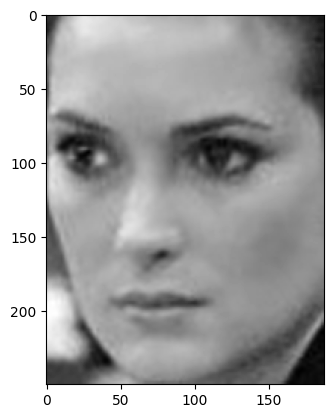

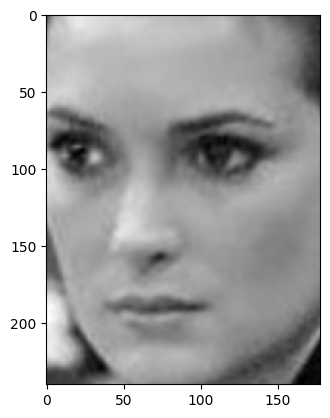

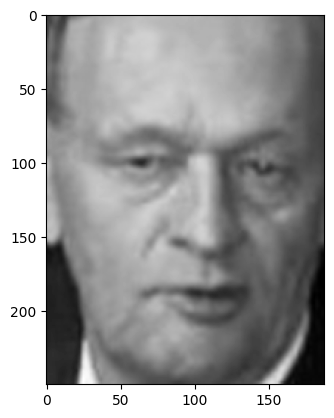

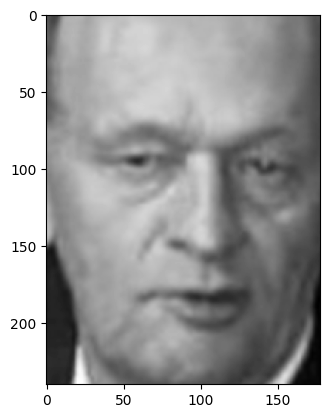

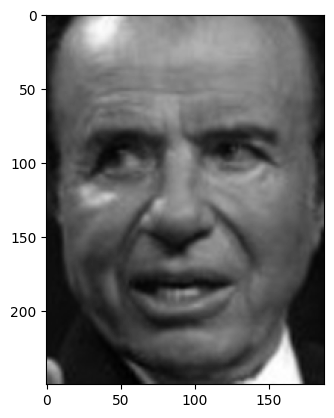

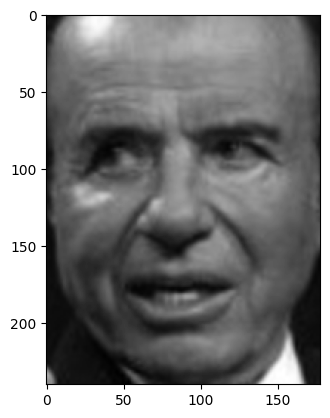

In [24]:
left = 5
top = 5
right = image_shape[1] - left
bottom = image_shape[0] - top

import PIL

for img in people.images[0:3, :, :]:
    #pil_img = PIL.Image.fromarray(np.uint8(img*255))
    pil_img = PIL.Image.fromarray(img)
    plt.figure()
    plt.imshow(np.array(pil_img))
    pil_img = pil_img.crop((left, top, right, bottom))
    plt.figure()
    plt.imshow(np.array(pil_img))

np.shape(np.array(pil_img))


https://github.com/scikit-learn/scikit-learn/issues/24942

In [25]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (3023, 250, 188)
Number of classes: 62


In [26]:
people.target_names

array(['Alejandro Toledo', 'Alvaro Uribe', 'Amelie Mauresmo',
       'Andre Agassi', 'Angelina Jolie', 'Ariel Sharon',
       'Arnold Schwarzenegger', 'Atal Bihari Vajpayee', 'Bill Clinton',
       'Carlos Menem', 'Colin Powell', 'David Beckham', 'Donald Rumsfeld',
       'George Robertson', 'George W Bush', 'Gerhard Schroeder',
       'Gloria Macapagal Arroyo', 'Gray Davis', 'Guillermo Coria',
       'Hamid Karzai', 'Hans Blix', 'Hugo Chavez', 'Igor Ivanov',
       'Jack Straw', 'Jacques Chirac', 'Jean Chretien',
       'Jennifer Aniston', 'Jennifer Capriati', 'Jennifer Lopez',
       'Jeremy Greenstock', 'Jiang Zemin', 'John Ashcroft',
       'John Negroponte', 'Jose Maria Aznar', 'Juan Carlos Ferrero',
       'Junichiro Koizumi', 'Kofi Annan', 'Laura Bush',
       'Lindsay Davenport', 'Lleyton Hewitt', 'Luiz Inacio Lula da Silva',
       'Mahmoud Abbas', 'Megawati Sukarnoputri', 'Michael Bloomberg',
       'Naomi Watts', 'Nestor Kirchner', 'Paul Bremer', 'Pete Sampras',
       'Rece

In [27]:
# count how often each target appears
counts = np.bincount(people.target)
# print counts next to target names:
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end='   ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39   Alvaro Uribe               35   Amelie Mauresmo            21   
Andre Agassi               36   Angelina Jolie             20   Ariel Sharon               77   
Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   Bill Clinton               29   
Carlos Menem               21   Colin Powell              236   David Beckham              31   
Donald Rumsfeld           121   George Robertson           22   George W Bush             530   
Gerhard Schroeder         109   Gloria Macapagal Arroyo    44   Gray Davis                 26   
Guillermo Coria            30   Hamid Karzai               22   Hans Blix                  39   
Hugo Chavez                71   Igor Ivanov                20   Jack Straw                 28   
Jacques Chirac             52   Jean Chretien              55   Jennifer Aniston           21   
Jennifer Capriati          42   Jennifer Lopez             21   Jeremy Greenstock          24   
Jiang Zemin                20 

In [28]:
87 * 65

5655

In [29]:
mask = np.zeros(people.target.shape, dtype=bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

X_people = people.data[mask]
y_people = people.target[mask]

# scale the grey-scale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability:
X_people = X_people / 255.

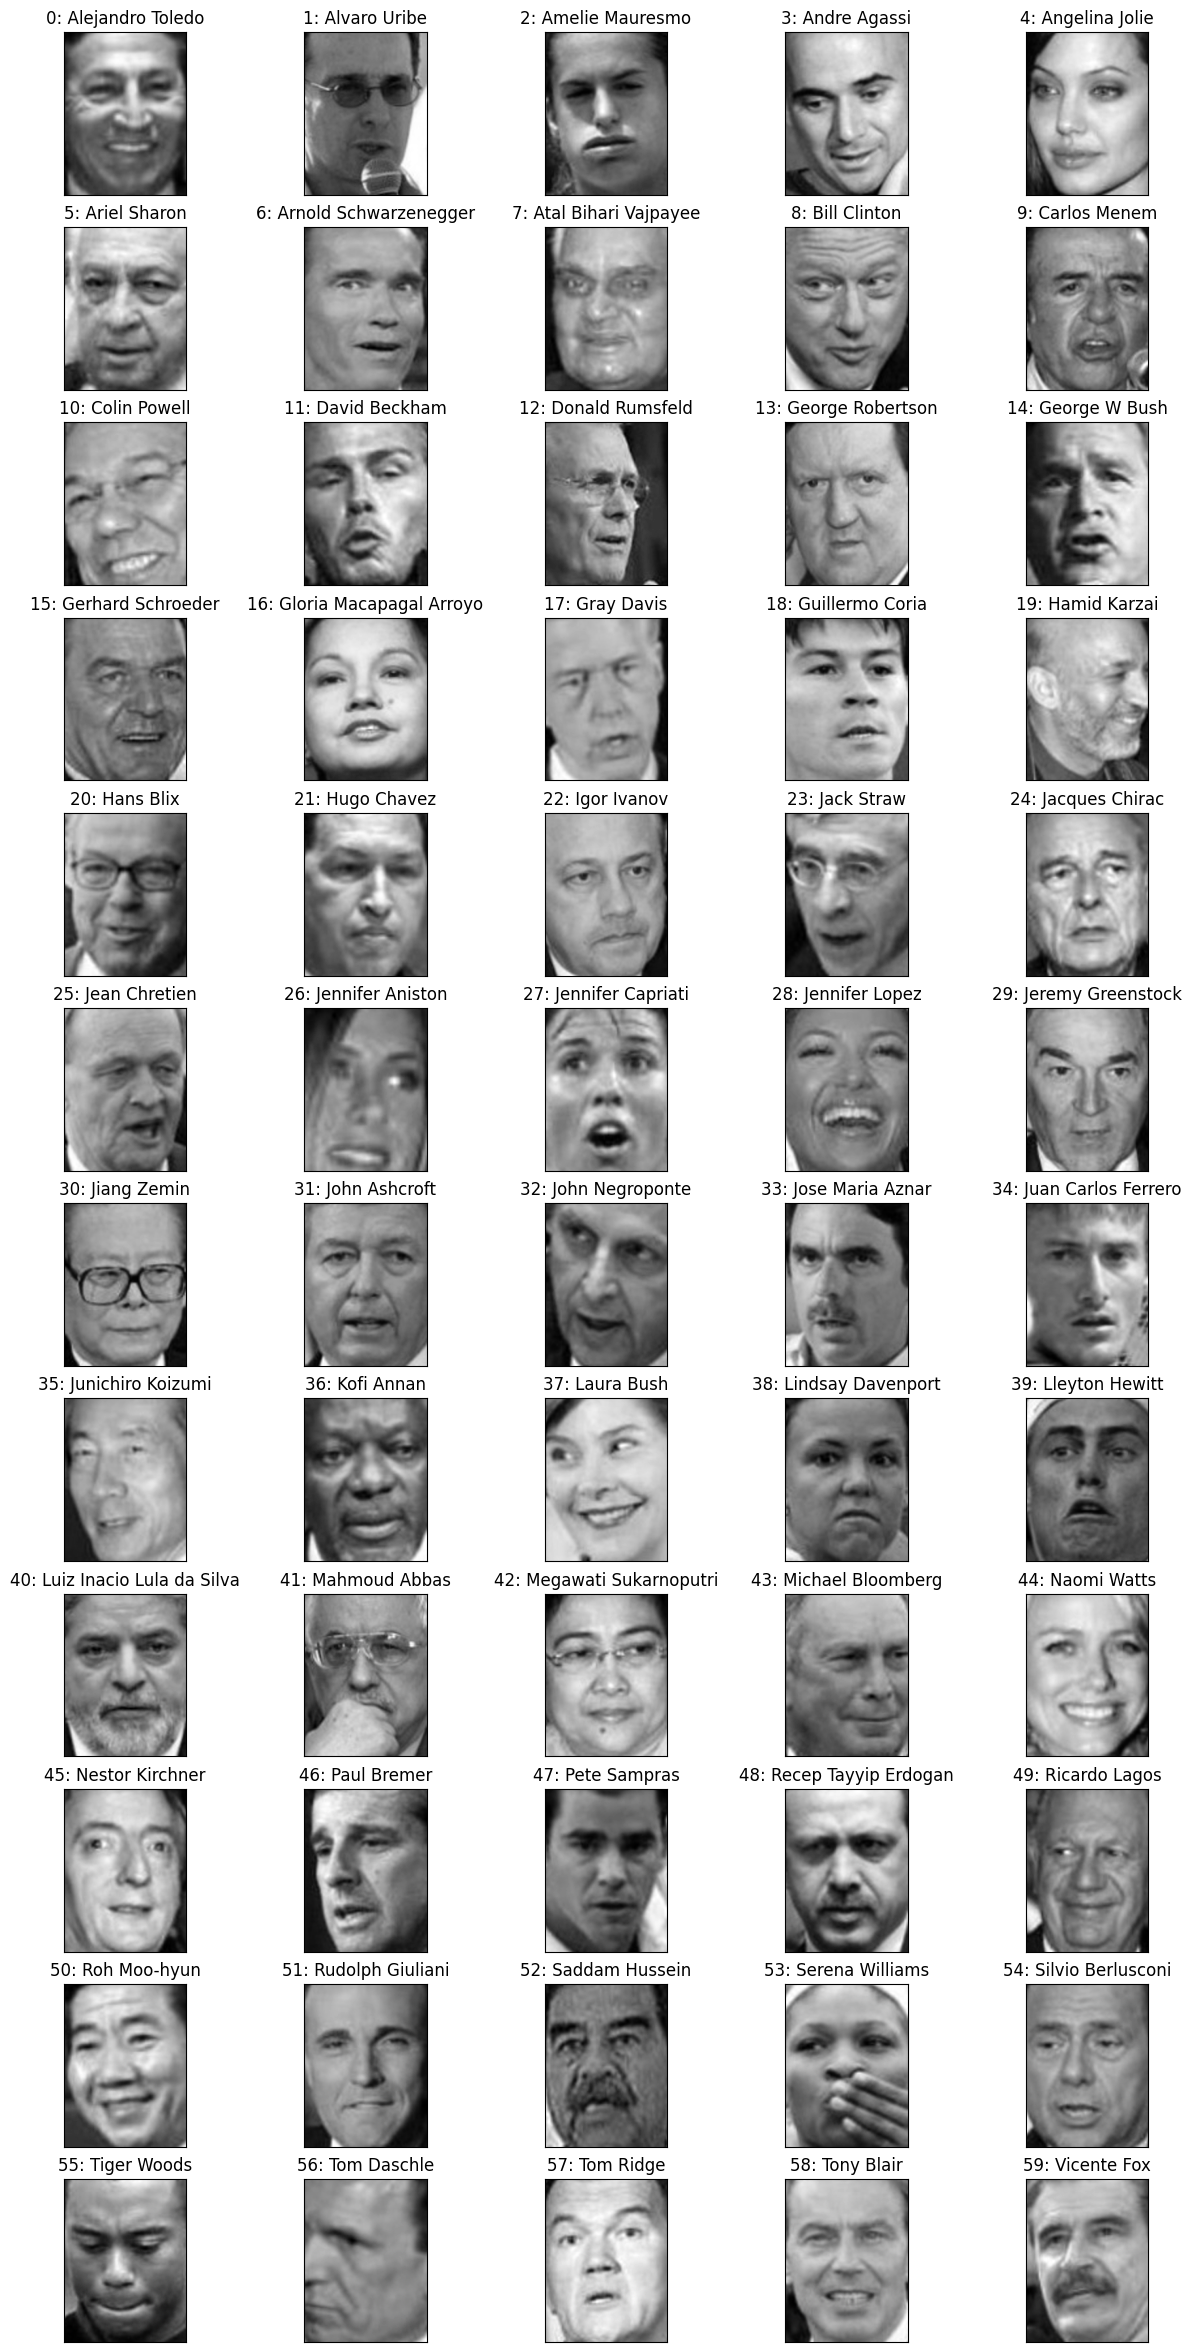

In [30]:
NumberOfPeople = np.unique(people.target).shape[0]
TargetNames = [];
n = 5

#find the first 5 images from each person
fig, axes = plt.subplots(12, 5, figsize=(15, 30),
                         subplot_kw={'xticks': (), 'yticks': ()})

for target, ax in zip(np.unique(people.target), axes.ravel()):
    #get the first n pictures from each person
    indices = np.where(people.target == target)[0][1:n + 1]
    TargetNames.append(people.target_names[target])

    image = people.images[indices[0]]
    ax.imshow(image)
    ax.set_title(str(target) + ': ' + TargetNames[target])



### (b) Principal Component Analysis

Apply now a principal component analysis `X_pca=pca.fit_transform(X_people)` and
extract the first 100 components of each image. Reconstruct the first 10 entries of the dataset
using the 100 components of the PCA transformed data by applying the
`pca.inverse_transform` method and reshaping the image to the original size using
np.reshape. 

What is the minimum number of components necessary such that you recognize
the persons? Try it out.


In [31]:
NumberOfPeople

62

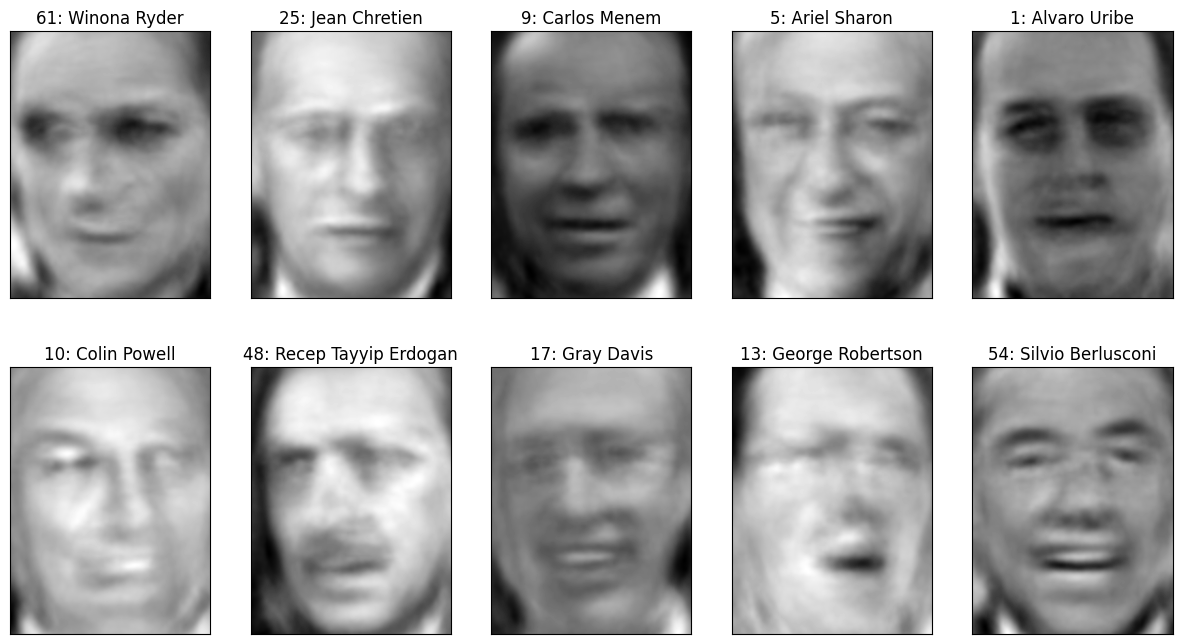

In [32]:
#extract eigenfaces from lfw data and transform data
from sklearn.decomposition import PCA

pca = PCA(n_components=100, whiten=True, random_state=0)
X_pca = pca.fit_transform(X_people)
#X_pca = pca.transform(X_people)

image_shape = people.images[0].shape
NumberOfSamples = X_pca.shape[0]

fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})

for ix, target, ax in zip(np.arange(NumberOfSamples), y_people, axes.ravel()):
    image = np.reshape(pca.inverse_transform(X_pca[ix, :]), image_shape)
    ax.imshow(image)
    ax.set_title(str(y_people[ix]) + ': ' + people.target_names[target])


### (c) Apply DBSCAN on these features

Import DBSCAN class from sklearn.cluster, generate an instance called dbscan and
apply it to the pca transformed data X_pca and extract the cluster labels using labels
= dbscan.fit_predict(X_pca). Use first the standard parameters for the method and
check how many unique clusters the algorithm could find by analyzing the number of
unique entries in the predicted cluster labels.

In [33]:
# apply DBSCAN with default parameters
from sklearn.cluster import DBSCAN

dbscan = DBSCAN()
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1]


### (d) Variation of the `eps` parameter

Change the parameter eps of the dbscan using `dbscan(min_samples=3, eps=5)`. Change
the value of eps in the range from 5 to 10 in steps of 0.5 using a for loop and check for
each value of eps how many clusters could be determined.

In [34]:
for eps in np.linspace(6, 8, 51):
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(X_pca)
    print("Number of clusters: {}".format(len(np.unique(labels))))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))


eps=6.0
Number of clusters: 4
Cluster sizes: [2050    3    7    3]

eps=6.04
Number of clusters: 4
Cluster sizes: [2048    3    7    5]

eps=6.08
Number of clusters: 4
Cluster sizes: [2048    3    7    5]

eps=6.12
Number of clusters: 4
Cluster sizes: [2048    3    7    5]

eps=6.16
Number of clusters: 5
Cluster sizes: [2045    3    7    3    5]

eps=6.2
Number of clusters: 6
Cluster sizes: [2042    3    7    3    3    5]

eps=6.24
Number of clusters: 6
Cluster sizes: [2042    3    7    3    3    5]

eps=6.28
Number of clusters: 6
Cluster sizes: [2042    3    7    3    3    5]

eps=6.32
Number of clusters: 6
Cluster sizes: [2042    3    7    3    3    5]

eps=6.36
Number of clusters: 6
Cluster sizes: [2042    3    7    3    3    5]

eps=6.4
Number of clusters: 6
Cluster sizes: [2041    3    7    3    6    3]

eps=6.44
Number of clusters: 7
Cluster sizes: [2036    3    4    7    6    3    4]

eps=6.48
Number of clusters: 7
Cluster sizes: [2032    3    5    7    7    6    3]

eps=6.52
N

### (e) Maxumum number of clusters found

Select the value of `eps` where the numbers of clusters found is maximum and plot the
members of the clusters found using the follwing python code.

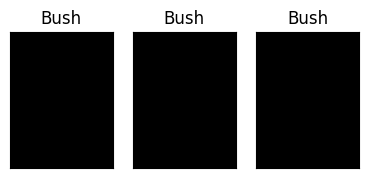

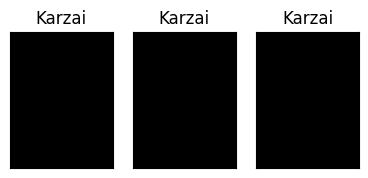

In [35]:
dbscan = DBSCAN(min_samples=3, eps=7.640000000000001)
labels = dbscan.fit_predict(X_pca)

for cluster in range(max(labels) + 1):
    mask = labels == cluster
    n_images = np.sum(mask)
    if n_images < 7:
        fig, axes = plt.subplots(1, n_images, figsize=(n_images * 1.5, 4),
                                 subplot_kw={'xticks': (), 'yticks': ()})
        for image, label, ax in zip(X_people[mask], y_people[mask], axes):
            ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
            ax.set_title(people.target_names[label].split()[-1])

# Bonus: Agglomerative and Spectral Clustering (optional)

In [36]:
# %% using other cluster algorithms learner on the pca transformed data
from time import time
from sklearn import cluster
from sklearn.neighbors import kneighbors_graph

n_clusters = 14

clustering_names = ['SpectralClustering', 'Ward', 'AverageLinkage']

connectivity = kneighbors_graph(X_pca, n_neighbors=n_clusters, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

spectral = cluster.SpectralClustering(n_clusters=n_clusters,
                                      eigen_solver='arpack',
                                      # affinity="nearest_neighbors"
                                      )

ward = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='ward',
                                       connectivity=connectivity)

average_linkage = cluster.AgglomerativeClustering(
    linkage="average",
    # affinity="cityblock",
    n_clusters=n_clusters,
    connectivity=connectivity)

clustering_algorithms = [spectral, ward, average_linkage]

# %matplotlib inline
for name, algorithm in zip(clustering_names, clustering_algorithms):
    # predict cluster memberships
    print(algorithm)
    t0 = time()
    algorithm.fit(X_pca)
    t1 = time()

    if hasattr(algorithm, 'labels_'):
        labels = algorithm.labels_.astype(np.int)
    else:
        labels = algorithm.predict(X_pca)

    print("%s: %.2g sec" % (name, t1 - t0))
    print('labels found: %i' % (max(labels) + 1))
    print("_____________________________________________")
    print("       %s                                     " % (name))
    print("_____________________________________________")

    for cluster in range(max(labels) + 1):
        mask = labels == cluster
        ind = np.where(mask == True)[0]
        n_images = np.size(ind)
        submask = np.zeros(X_pca.shape[0])
        submask = submask.astype(dtype=bool)
        submask[ind] = True
        #n_images =  np.sum(mask)
        #print(n_images)

        max_image = np.min([n_images, 8])
        print('max image: %i\n' % (max_image))
        fig, axes = plt.subplots(1, max_image, figsize=(max_image * 3, 3),
                                 subplot_kw={'xticks': (), 'yticks': ()})

        if max_image == 1:
            print(ind[0])
            image = X_people[ind[0]]
            label = y_people[ind[0]]
            plt.imshow(image.reshape(image_shape), vmin=0, vmax=1)
            plt.title(people.target_names[label].split()[-1])
        else:
            for image, label, ax in zip(X_people[submask], y_people[submask], axes):
                ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
                ax.set_title(people.target_names[label].split()[-1])

        plt.show()

SpectralClustering(eigen_solver='arpack', n_clusters=14)


/Users/davebrunner/.local/share/virtualenvs/FTP_MachLe-TAxQAUJy/lib/python3.12/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations